# Chronicle Flood Database Intersection with GHSL Built Area dataset

This notebook provides a comprehensive analysis of the Chronicle urban flood dataset, containing over 880,000 flood events worldwide from 2000-2025.


# Imports & Configuration

In [8]:
import pandas as pd
import geopandas as gpd
from shapely import wkt, geometry
from shapely.geometry import box
import rasterio
from rasterstats import zonal_stats
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
# --- CONFIGURATION ---

# File Paths
chronicle_ds_csv_path = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_preliminary_huji.csv"
ghs_urban_raster_path = r"D:\Development\RESEARCH\Raanana\data\esa_worldcover\GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

# Processing Settings
# Set to an integer (e.g., 10000) for testing, or None for full dataset
SAMPLE_SIZE = None

# Data Loading & Processing

In [ ]:
if SAMPLE_SIZE:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path, nrows=SAMPLE_SIZE)
else:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path)

# 2. Parse Geometries
print("Parsing WKT geometries...")
chronicle_raw_df['geometry'] = chronicle_raw_df['geometry_wkt'].apply(wkt.loads)

# 3. Create GeoDataFrame
chronicle_gdf = gpd.GeoDataFrame(chronicle_raw_df, geometry='geometry')
chronicle_gdf.set_crs(epsg=4326, inplace=True)

# 4. Reproject
with rasterio.open(ghs_urban_raster_path) as src:
    ghs_raster_crs = src.crs
    ghs_nodata_value = src.nodata
    print(f"Raster CRS: {ghs_raster_crs}")
    
    print("Reprojecting polygons...")
    chronicle_projected_gdf = chronicle_gdf.to_crs(ghs_raster_crs)

# 5. Calculate Zonal Statistics (WITH PROGRESS TRACKING)
print("Calculating zonal stats in chunks...")

# -- PROGRESS LOGIC START --
total_rows = len(chronicle_projected_gdf)
# We want 10 updates, so we divide total rows by 10
chunk_size = math.ceil(total_rows / 10) 
all_stats = []

# Iterate through the DataFrame in chunks
for i in range(0, total_rows, chunk_size):
    # Slice the dataframe
    subset = chronicle_projected_gdf.iloc[i : i + chunk_size]
    
    # Run stats just for this chunk
    chunk_stats = zonal_stats(
        subset,
        ghs_urban_raster_path,
        stats=['sum'],
        nodata=ghs_nodata_value
    )
    
    # Accumulate results
    all_stats.extend(chunk_stats)
    
    # Calculate and print progress
    current_row = min(i + chunk_size, total_rows)
    percent_complete = int((current_row / total_rows) * 100)
    print(f"{percent_complete}% complete... ({current_row}/{total_rows})")

# Convert accumulated list to DataFrame
urban_stats_df = pd.DataFrame(all_stats)
# -- PROGRESS LOGIC END --

# 6. Calculate Urban Percentage
print("Calculating percentages...")
chronicle_projected_gdf['urban_built_up_area_m2'] = urban_stats_df['sum'].fillna(0)
chronicle_projected_gdf['polygon_total_area_m2'] = chronicle_projected_gdf.area

chronicle_projected_gdf['urban_percentage'] = np.where(
    chronicle_projected_gdf['polygon_total_area_m2'] > 0,
    (chronicle_projected_gdf['urban_built_up_area_m2'] / chronicle_projected_gdf['polygon_total_area_m2']) * 100,
    0
)

# 7. Final Clean DataFrame
chronicle_urban_df = pd.DataFrame(chronicle_projected_gdf.drop(columns='geometry'))

print(f"--- Done! Processed {len(chronicle_urban_df)} records. ---")

## Save as a pickle

In [9]:
# Save the DataFrame to a pickle file at the specified path
# chronicle_urban_df.to_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

In [10]:
# Load the DataFrame from the specified path
chronicle_urban_df = pd.read_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

--- Statistics ---
Total events processed: 882972
Events > 20% urban: 214302 (24.27%)
CDF at 20% (Events <= 20%): 75.73%
------------------


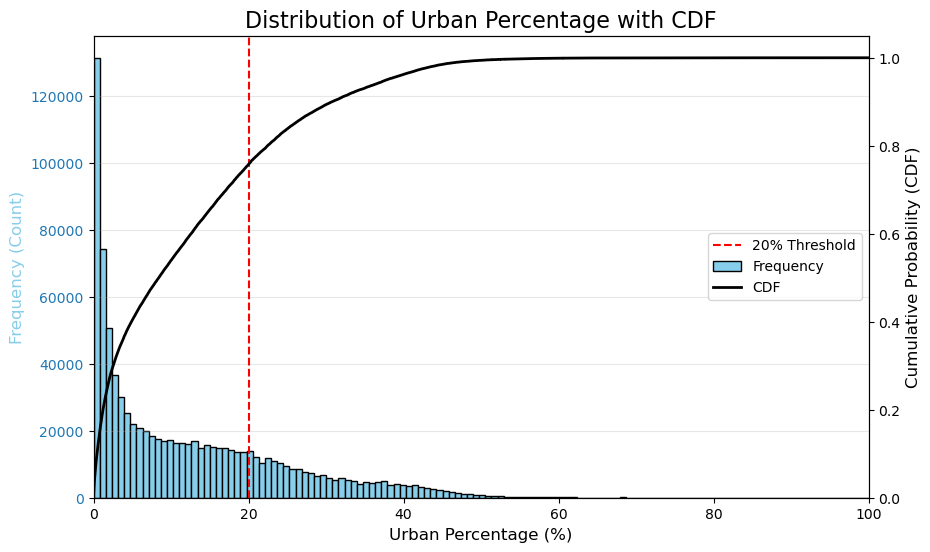

In [11]:
# --- 1. CALCULATION ---
threshold = 20

# Filter events above threshold
events_above_threshold = chronicle_urban_df[chronicle_urban_df['urban_percentage'] > threshold]
count_above = len(events_above_threshold)
total_events = len(chronicle_urban_df)

# Calculate CDF at the specific threshold (Percentage of events <= threshold)
cdf_at_threshold = (chronicle_urban_df['urban_percentage'] <= threshold).mean() * 100

print("--- Statistics ---")
print(f"Total events processed: {total_events}")
print(f"Events > {threshold}% urban: {count_above} ({100 - cdf_at_threshold:.2f}%)")
print(f"CDF at {threshold}% (Events <= {threshold}%): {cdf_at_threshold:.2f}%")
print("------------------")

# --- 2. PLOTTING ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot A: Histogram (Left Axis)
# We use density=False to see the actual counts
ax1.hist(chronicle_urban_df['urban_percentage'], bins=1000, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('Urban Percentage (%)', fontsize=12)
ax1.set_ylabel('Frequency (Count)', fontsize=12, color='skyblue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Plot B: CDF (Right Axis)
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

# Create CDF data
sorted_data = np.sort(chronicle_urban_df['urban_percentage'])
yvals = np.arange(len(sorted_data)) / float(len(sorted_data) - 1)

# Plot the CDF line
ax2.plot(sorted_data, yvals, color='black', linewidth=2, label='CDF')
ax2.set_ylabel('Cumulative Probability (CDF)', fontsize=12, color='black')
ax2.set_ylim(0, 1.05) # CDF goes from 0 to 1

# Add vertical threshold line
# We add it to ax1 but it crosses both
ax1.axvline(threshold, color='red', linestyle='dashed', linewidth=1.5, label=f'{threshold}% Threshold')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right')

plt.title('Distribution of Urban Percentage with CDF', fontsize=16)
plt.show()

In [12]:
# Filter with parentheses to handle operator precedence correctly
thresh_chronicle_urban_df = chronicle_urban_df[
    (chronicle_urban_df['urban_percentage'] > threshold) & 
    (chronicle_urban_df['urban_percentage'] <= 100)
]
thresh_chronicle_urban_df

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage
2,2,931831f75479454cb3938811e64ce882,28.562733,v3.1,9.466848e+08,9.466848e+08,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...",3757833.0,1.180029e+07,31.845253
3,3,91bc68dde43646289c9e75b7d59e1711,108.562378,v3.1,9.466848e+08,9.466848e+08,1,"POLYGON ((30.936502 -29.872152, 30.928104 -29....",26634641.0,1.273836e+08,20.908999
4,4,8b849511de80423f98918f55af323e7e,0.104375,v3.1,9.466848e+08,9.466848e+08,1,"POLYGON ((16.547385 38.687964, 16.549982 38.68...",49138.0,1.051849e+05,46.715826
6,6,8995bd586b894e21b6a780941c98af5b,6.361776,v3.1,9.466848e+08,9.466848e+08,1,"POLYGON ((-3.3879473 38.751847, -3.405887 38.7...",1647176.0,5.666359e+06,29.069392
9,9,77ce167a60fe424ea0fc2e11ad22f2f9,11.840811,v3.1,9.466848e+08,9.466848e+08,1,"POLYGON ((-1.167924 38.010512, -1.1193555 37.9...",3334239.0,1.364678e+07,24.432430
...,...,...,...,...,...,...,...,...,...,...,...
882939,882939,c700d42c8ea4470e86627fde1a8f4723,0.519407,v3.1,1.761350e+09,1.761350e+09,1,"POLYGON ((100.71504 4.825252, 100.70601 4.8207...",138841.0,4.934416e+05,28.137271
882943,882943,bf17e86512b440218e6bbd17b19a4f6f,1.444443,v3.1,1.761350e+09,1.761350e+09,1,"POLYGON ((-69.974007 18.450914, -69.968881 18....",603603.0,1.342677e+06,44.955204
882948,882948,d283241a57324f2a9be681f60c98f2fa,1.443353,v3.1,1.761350e+09,1.761350e+09,1,"POLYGON ((-69.998662 18.464414, -69.985015 18....",557227.0,1.608517e+06,34.642277
882953,882953,fe46569c7b1d40a8861d83f3bfdd1f32,1.412024,v3.1,1.761350e+09,1.761350e+09,1,"POLYGON ((-58.477773 -34.578427, -58.470819 -3...",542467.0,1.190291e+06,45.574318


In [13]:
# 1. Filter rows with percentage > 100
anomalies = thresh_chronicle_urban_df[thresh_chronicle_urban_df['urban_percentage'] > 100]
count = len(anomalies)


print(f"Total events checked: {len(thresh_chronicle_urban_df)}")
print(f"Events with > 100% urban area: {count}")

if count > 0:
    max_val = anomalies['urban_percentage'].max()
    print(f"Highest value found: {max_val:.2f}%")
    
    print("\nTop 5 Anomalies (Preview):")
    # Show UUID, Percentage, and Total Area (often happens in very small polygons)
    print(anomalies[['uuid', 'urban_percentage', 'polygon_total_area_m2']].head())
else:
    print("Status: OK. No values above 100% found.")

--- Data Integrity Check ---
Total events checked: 214204
Events with > 100% urban area: 0
Status: OK. No values above 100% found.


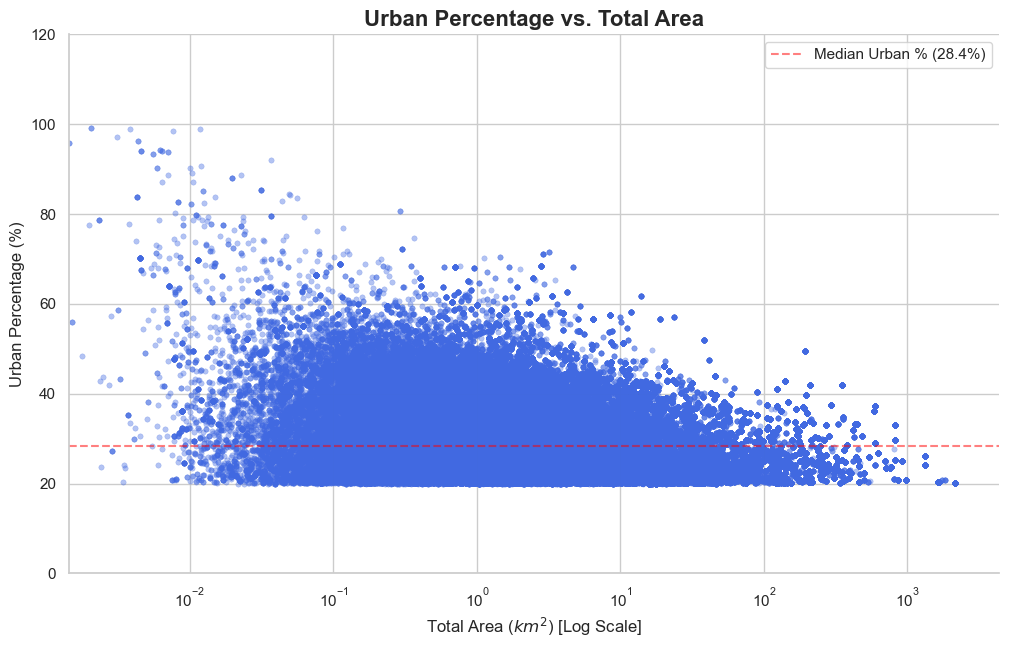

In [14]:

# 1. Create a copy and convert area to km² for better readability
# (1 km² = 1,000,000 m²)
df_plot = thresh_chronicle_urban_df.copy()
df_plot['area_km2'] = df_plot['polygon_total_area_m2'] / 1_000_000

# 2. Setup the figure
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. Create Scatter Plot
sns.scatterplot(
    data=df_plot,
    x='area_km2',
    y='urban_percentage',
    alpha=0.4,       # Transparency helps visualize overlapping points
    edgecolor=None,  # Removes borders from dots for a cleaner look
    s=15,            # Dot size
    color='royalblue'
)

# 4. Set Log Scale for X-axis (Crucial for Area distribution)
plt.xscale('log')

# 5. Set limits and styling
plt.ylim(0, 120)
plt.xlim(left=df_plot['area_km2'].min()) # Start from the smallest polygon

plt.title('Urban Percentage vs. Total Area', fontsize=16, fontweight='bold')
plt.xlabel('Total Area ($km^2$) [Log Scale]', fontsize=12)
plt.ylabel('Urban Percentage (%)', fontsize=12)

# 6. Add a visual helper line (e.g., median urban percentage)
median_val = df_plot['urban_percentage'].median()
plt.axhline(median_val, color='red', linestyle='--', alpha=0.5, label=f'Median Urban % ({median_val:.1f}%)')
plt.legend()

sns.despine()
plt.show()

In [24]:

# Extract coordinates from geometry for geographic analysis
def extract_centroid_coordinates(geometry_wkt_string):
    """Extract centroid coordinates from WKT geometry string."""
    try:
        if geometry_wkt_string.startswith(('POLYGON', 'MULTIPOLYGON')):
            geom = wkt.loads(geometry_wkt_string)
            centroid = geom.centroid
            return centroid.y, centroid.x  # lat, lon
    except Exception:
        return None, None
    return None, None

# Process sample for geographic visualization
sample_size = len(thresh_chronicle_urban_df)
sample_events = thresh_chronicle_urban_df.sample(n=sample_size, random_state=42)

print(f"Processing {sample_size} events for geographic analysis...")

coordinates = []
areas = []
durations = []

for idx, row in sample_events.iterrows():
    lat, lon = extract_centroid_coordinates(row['geometry_wkt'])
    if lat is not None and lon is not None:
        coordinates.append([lon, lat])  # lon, lat order
        areas.append(row['area_km2'])
        durations.append(row['duration_days'])

coordinates = np.array(coordinates)
lons = coordinates[:, 0]
lats = coordinates[:, 1]
areas_array = np.array(areas)

print(f"Successfully processed {len(coordinates)} events")

Processing 214204 events for geographic analysis...
Successfully processed 214204 events


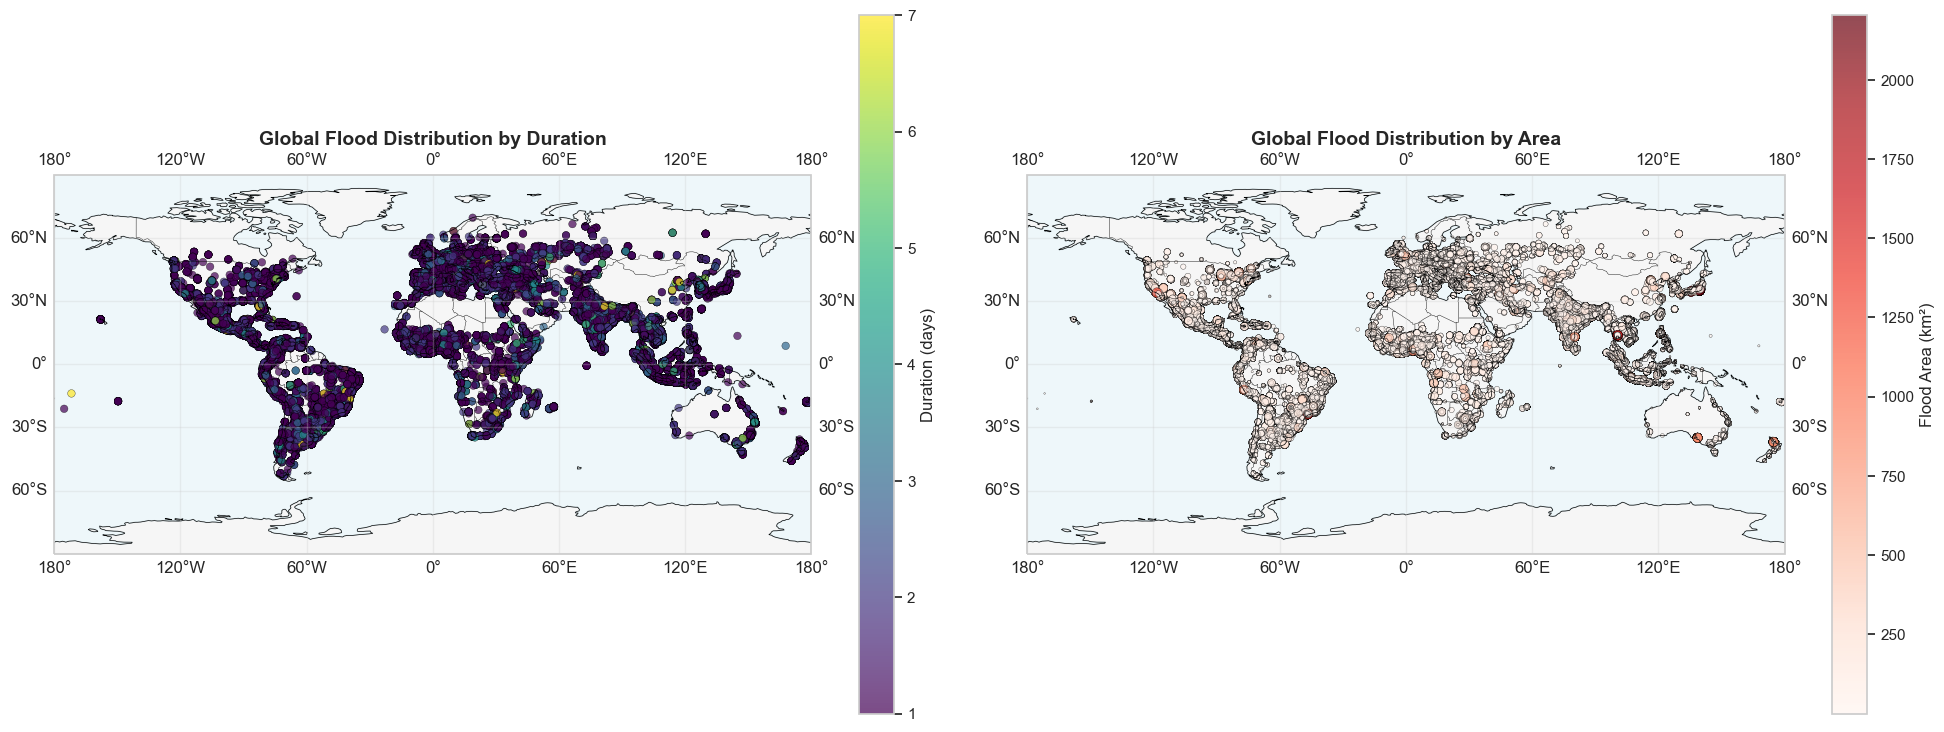

In [25]:
# Create global distribution maps
fig = plt.figure(figsize=(20, 12))

# Map 1: Distribution by duration
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')
ax1.add_feature(cfeature.OCEAN, alpha=0.2, color='lightblue')

scatter1 = ax1.scatter(lons, lats, c=durations, s=30, alpha=0.7, 
                      cmap='viridis', transform=ccrs.PlateCarree(), 
                      edgecolors='black', linewidth=0.3)
ax1.set_title('Global Flood Distribution by Duration', fontsize=14, fontweight='bold')
ax1.gridlines(draw_labels=True, alpha=0.3)

cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.6, pad=0.05)
cbar1.set_label('Duration (days)', fontsize=12)

# Map 2: Distribution by area
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')
ax2.add_feature(cfeature.OCEAN, alpha=0.2, color='lightblue')

sizes = np.log10(areas_array + 1) * 15
scatter2 = ax2.scatter(lons, lats, c=areas_array, s=sizes, alpha=0.7, 
                      cmap='Reds', transform=ccrs.PlateCarree(),
                      edgecolors='black', linewidth=0.3)
ax2.set_title('Global Flood Distribution by Area', fontsize=14, fontweight='bold')
ax2.gridlines(draw_labels=True, alpha=0.3)

cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.6, pad=0.05)
cbar2.set_label('Flood Area (km²)', fontsize=12)

plt.tight_layout()
plt.show()

In [23]:
sample_df

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage
62544,62544,8d3f3dd9907c4d9b97332476f84d5c71,0.688482,v3.1,1.348704e+09,1.348790e+09,2,"POLYGON ((-4.9060387 37.225444, -4.8939464 37....",266574.0,9.208620e+05,28.948312
743909,743909,23d089ccb41d416499d083d82ac67625,6.999599,v3.1,1.725667e+09,1.725754e+09,2,"POLYGON ((12.468742 41.850351, 12.472014 41.87...",1478521.0,5.492448e+06,26.919163
725114,725114,31bc8e2c5aea48c98025f80d3e9ec612,9.663686,v3.1,1.721866e+09,1.721866e+09,1,"POLYGON ((74.213076 19.584537, 74.227324 19.57...",1524142.0,6.114684e+06,24.925933
651197,651197,83b3f4e8eb4a40db8f8cc643b22a404f,3.360081,v3.1,1.701648e+09,1.701648e+09,1,"POLYGON ((101.43737 3.083145, 101.42356 3.0780...",501991.0,2.418507e+06,20.756232
294643,294643,56d91f06a20f43c29d982fcceda89de9,0.352987,v3.1,1.544573e+09,1.544573e+09,1,"POLYGON ((102.2548 -3.8004921, 102.25984 -3.79...",132869.0,3.721365e+05,35.704375
...,...,...,...,...,...,...,...,...,...,...,...
471185,471185,504b19550e4943858c65f7e8ff81eba0,39.823988,v3.1,1.631923e+09,1.631923e+09,1,"POLYGON ((-86.712025 36.100868, -86.7638209999...",7832956.0,3.567539e+07,21.956189
809439,809439,9d8ee680a9fc485b8818b46574359d92,9.482621,v3.1,1.744330e+09,1.744330e+09,1,"POLYGON ((-54.648378 -20.412431, -54.654338 -2...",2294266.0,8.032040e+06,28.563925
539002,539002,c5f7473737d043ec9547e1ecd8741a37,19.003438,v3.1,1.661818e+09,1.661818e+09,1,"POLYGON ((80.00737700000001 9.6845006, 80.0390...",3115015.0,1.365811e+07,22.807073
319699,319699,dc308b466aea45f5a718cfa7698fbe6a,9.492254,v3.1,1.562198e+09,1.562285e+09,2,"POLYGON ((100.58712 13.577709, 100.59308 13.59...",1663831.0,6.133290e+06,27.127870


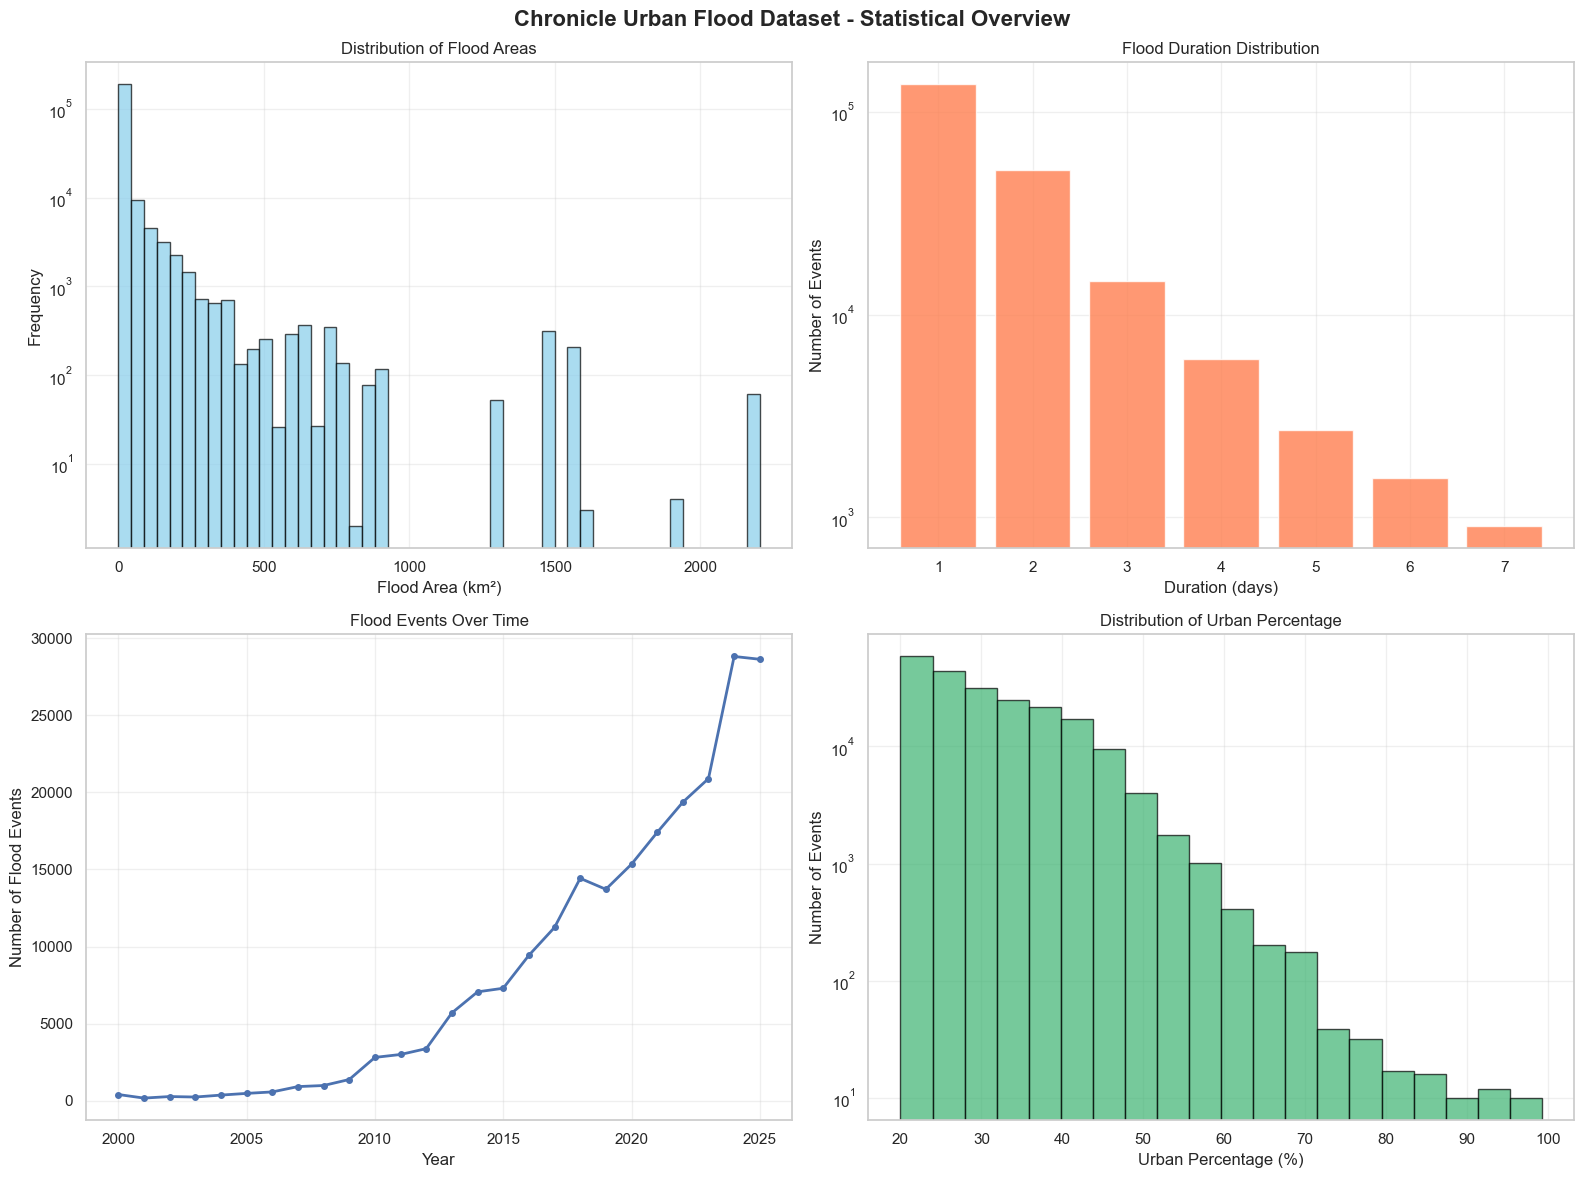

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Create comprehensive statistical visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Chronicle Urban Flood Dataset - Statistical Overview', fontsize=16, fontweight='bold')

# 1. Flood area distribution (log scale)
axes[0,0].hist(thresh_chronicle_urban_df['area_km2'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Flood Area (km²)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Flood Areas')
axes[0,0].set_yscale('log')
axes[0,0].grid(True, alpha=0.3)

# 2. Duration distribution
duration_counts = thresh_chronicle_urban_df['duration_days'].value_counts().sort_index()
axes[0,1].bar(duration_counts.index, duration_counts.values, color='coral', alpha=0.8)
axes[0,1].set_xlabel('Duration (days)')
axes[0,1].set_ylabel('Number of Events')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Flood Duration Distribution')
axes[0,1].grid(True, alpha=0.3)

# 3. Temporal distribution by year
df_temp = thresh_chronicle_urban_df.copy()
# Ensure start_time is treated correctly (assuming seconds)
df_temp['year'] = pd.to_datetime(df_temp['start_time'], unit='s').dt.year
yearly_counts = df_temp['year'].value_counts().sort_index()

axes[1,0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=4)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Flood Events')
axes[1,0].set_title('Flood Events Over Time')
axes[1,0].grid(True, alpha=0.3)

# 4. Urban Percentage Distribution (The requested change)
# Using 20 bins to clearly see the distribution from 0 to 100%
axes[1,1].hist(thresh_chronicle_urban_df['urban_percentage'], bins=20, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Urban Percentage (%)')
axes[1,1].set_ylabel('Number of Events')
axes[1,1].set_yscale('log')
axes[1,1].set_title('Distribution of Urban Percentage')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualization Helper Functions

In [15]:
def get_pixels_from_projected_geom(geom_projected, raster_path):
    """
    Extracts pixels from the raster that intersect with the given geometry.
    Returns a GeoDataFrame of pixel squares with their urban percentage.
    """
    minx, miny, maxx, maxy = geom_projected.bounds
    pixel_geoms, pixel_percentages = [], []

    with rasterio.open(raster_path) as src:
        # Read only the window covering the polygon bounds
        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, transform=src.transform)
        data = src.read(1, window=window)
        window_transform = src.window_transform(window)
        height, width = data.shape
        
        for row in range(height):
            for col in range(width):
                val = data[row, col]
                if val >= 0:
                    # Create pixel polygon (Square)
                    x1, y1 = window_transform * (col, row)
                    x2, y2 = window_transform * (col + 1, row + 1)
                    pixel_poly = box(min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
                    
                    # Strict check: pixel must touch/intersect the polygon
                    if pixel_poly.intersects(geom_projected):
                        total_area = pixel_poly.area
                        pct = (val / total_area * 100) if total_area > 0 else 0
                        
                        pixel_geoms.append(pixel_poly)
                        pixel_percentages.append(min(pct, 100.0))

    if not pixel_percentages: 
        return gpd.GeoDataFrame()
    
    return gpd.GeoDataFrame(
        {'urban_pct': pixel_percentages}, 
        geometry=pixel_geoms, 
        crs=src.crs
    )

def get_pct_color(value):
    """Returns hex color from Green (0%) to Red (100%)"""
    norm_val = value / 100.0
    cmap = plt.get_cmap('RdYlGn_r') 
    return mcolors.to_hex(cmap(norm_val))

# Selected-event Interactive Map Visualization

In [16]:
# --- SELECT EVENT TO VISUALIZE ---
EVENT_INDEX = 500    # Change this index to view different events

In [17]:
if EVENT_INDEX >= len(chronicle_projected_gdf):
    raise ValueError(f"Index {EVENT_INDEX} out of range.")

# 1. Get Event Data
geom_projected = chronicle_projected_gdf.iloc[EVENT_INDEX]['geometry']
event_uuid = chronicle_urban_df.iloc[EVENT_INDEX]['uuid']
urban_pct_total = chronicle_urban_df.iloc[EVENT_INDEX]['urban_percentage']

print(f"Visualizing Event Index: {EVENT_INDEX}")
print(f"UUID: {event_uuid}")
print(f"Total Urban Percentage: {urban_pct_total:.2f}%")

# 2. Extract Pixels (Intersecting only)
print("Extracting pixels...")
pixel_gdf_projected = get_pixels_from_projected_geom(geom_projected, ghs_urban_raster_path)

# 3. Prepare Map Data (Convert to WGS84 for Folium)
geom_wgs84 = gpd.GeoSeries([geom_projected], crs=chronicle_projected_gdf.crs).to_crs(epsg=4326)[0]

if not pixel_gdf_projected.empty:
    pixel_gdf_wgs84 = pixel_gdf_projected.to_crs(epsg=4326)
else:
    print("Warning: No intersecting pixels found.")
    pixel_gdf_wgs84 = None

# 4. Build Map
centroid = geom_wgs84.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13, tiles=None)

# Add Base Layers
folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Tiles © Esri",
    name="Satellite",
).add_to(m)

# Layer 1: Flood Polygon (Bottom, Hollow Blue)
folium.GeoJson(
    geom_wgs84,
    name="Flood Event Boundary",
    style_function=lambda x: {'color': 'blue', 'weight': 3, 'fillOpacity': 0}
).add_to(m)

# Layer 2: Pixels (Top, Colored by Density)
if pixel_gdf_wgs84 is not None:
    folium.GeoJson(
        pixel_gdf_wgs84,
        name="Urban Density Pixels",
        style_function=lambda feature: {
            'fillColor': get_pct_color(feature['properties']['urban_pct']),
            'color': 'none',       
            'fillOpacity': 0.6, # Constant opacity so 0% is visible as green
        },
        tooltip=folium.GeoJsonTooltip(fields=['urban_pct'], aliases=['Density (%):'], localize=True)
    ).add_to(m)

# Legend
legend_html = '''
 <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 80px; 
 border:2px solid grey; z-index:9999; background-color:white; opacity: 0.9; padding: 10px; border-radius: 5px;">
 <b>Urban Density (%)</b><br>
 <div style="background: linear-gradient(to right, green, yellow, red); width: 100%; height: 20px; border: 1px solid #ccc;"></div>
 <div style="display: flex; justify-content: space-between; font-size: 12px;"><span>0%</span><span>50%</span><span>100%</span></div>
 </div>
 '''
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)

# Display Map
m

NameError: name 'chronicle_projected_gdf' is not defined